# Entendendo o Problema

O gerenciamento do relacionamento com os clientes tem como um dos seus objetivos
centrais aumentar o número de clientes ativos da empresa - e a retenção desses clientes é crítica
para seu sucesso. Sendo assim, um time foi mobilizado para garantir o desenvolvimento da
estratégia de retenção de clientes e, sabendo do seu potencial analítico, você foi convocado para
esse desafio.

Em busca de uma maior compreensão das particularidades do negócio e de melhor
entendimento do cenário do churn, vocês optaram por realizar uma análise exploratória dos
dados. Em um primeiro momento algumas hipóteses foram levantadas visando direcionar esse
desenvolvimento inicial e, considerando a base de dados disponibilizada e um período de churn
de 1 ano, foi requisitado a você a validação da seguinte hipótese:

“O churn de novos clientes é maior do que o churn de clientes ativos”

## O que é Churn?

Termo usado para descrever a rotatividade dos clientes de serviços de uma empresa. Para este caso, vamos considerar
um churn aquele cliente que utilizou os serviços de locação em um ano e não voltou a utilizar novamente nos anos 
posteriores.

![Image of Yaktocat](https://www.idealmarketing.com.br/blog/wp-content/uploads/2018/06/Churn_01.jpg)






In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Estudando os dados

In [2]:
df = pd.read_csv(r'base_dados\base_teste.csv')

In [7]:
df.head()

,Unnamed: 0,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente
0,0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1
1,1,Springfield,Springfield,SPF030834,Ônibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1
2,2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1
3,3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1
4,4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1


### **Dicionário de Dados**

- **Unnamed:** coluna índice que consta no arquivo. Não tem relevancia para o estudo.
- **cidade_retirada:** cidade onde o transporte foi retirado pelo cliente;
- **cidade_devolucao:** cidade onde o transporte foi devolvido pelo cliente;
- **cd_contrato:** código do contrato do cliente para aquela locação específica. Cada contrato é unico por locação;
- **transporte_locado:** tipo dos transportes locados;
- **data_abertura_contrato:** data e hora de quando o contrato iniciou;
- **qtd_diarias:** quantidade de diárias o transporte será locado;
- **data_fechamento_contrato:** data e hora de quando o contrato encerrou;
- **qtd_hora_extra:** quantidade de horas extras realizadas além do contrato original;
- **cd_cliente:** identifica unicamente um cliente. Através deste campo é possível identificar todos os contratos realizado por um cliente.

### **Analisando os tipos de dados disponíveis**

In [8]:
df.dtypes

Unnamed: 0                   int64
cidade_retirada             object
cidade_devolucao            object
cd_contrato                 object
transporte_locado           object
data_abertura_contrato      object
qtd_diarias                  int64
data_fechamento_contrato    object
qtd_hora_extra               int64
cd_cliente                   int64
dtype: object

### **Analisando dados nulos**

In [46]:
df.isnull().sum()

Unnamed: 0                  0
cidade_retirada             0
cidade_devolucao            0
cd_contrato                 0
transporte_locado           0
data_abertura_contrato      0
qtd_diarias                 0
data_fechamento_contrato    0
qtd_hora_extra              0
cd_cliente                  0
ano_abertura_contrato       0
ano_primeiro_contrato       0
ano_ultimo_contrato         0
churn                       0
dtype: int64

#### **Análise:**
- É possível identificar que o dataframe está bem formado, sem a presença de dados nulos. Isso elimina uma etapa de tratamento de dados com essa característica.

### **Identifiando o Churn de Clientes**
- Para identificar os clientes que realizaram cancelamentos, consideramos os clientes que utilizaram o serviço em um ano e deixaram de utilizar o serviço posteriormente.
- Utilizei dois critérios para identificar um "Churn", são eles: 
    - Clientes que utilizaram somente no ano do primeiro contrato e nunca mais voltaram a utilizar;
    - Clientes que utilizaram por dois anos seguidos e depois não utilizaram novamente.

Para conseguir essa identificação, fiz as seguintes transformações no datafrme:
    - Incluí um atributo somente com o ano de abertura de cada contrato;
    - Incluí um atributo com o ano de realização do primeiro contrato de cada cliente;
    - Incluí um atributo com o ano de realização do último contrato de cada cliente.  

In [10]:
df['ano_abertura_contrato'] = pd.to_datetime(df.data_abertura_contrato).dt.year
df['ano_primeiro_contrato'] = df.apply(lambda x: df[df.cd_cliente == x.cd_cliente]['ano_abertura_contrato'].min(), axis=1) 
df['ano_ultimo_contrato'] = df.apply(lambda x: df[df.cd_cliente == x.cd_cliente]['ano_abertura_contrato'].max(), axis=1) 


## Identificando a primeira parte de "Churn".

- Para identificar os clientes com "churn", inicialmente busquei todos os clientes cujo ano do primeiro contrato seja igual ao ano do último contrato. Isso demonstra que esses clientes não voltaram a trabalhar com locações desta empresa. 

In [51]:
df['churn'] = df.apply(lambda x: True if x.ano_primeiro_contrato==x.ano_ultimo_contrato else False, axis=1)

In [52]:
df.groupby('ano_primeiro_contrato').agg(clientes=('cd_cliente','nunique'),
                                        qtd_chun=('churn','sum')).reset_index()

,ano_primeiro_contrato,clientes,qtd_chun
0,2015,26892,1928
1,2016,6852,1995
2,2017,4092,1953
3,2018,2935,1992
4,2019,2310,2068
5,2020,1761,1936


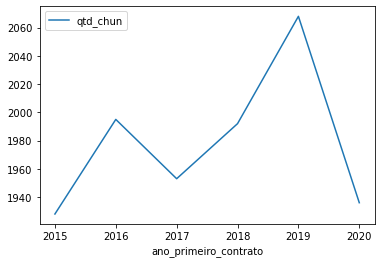

In [53]:
df.groupby('ano_primeiro_contrato').agg(qtd_chun=('churn','sum')).plot();

### **Análise:**

Nesta primeira etapa, é possível identificar uma tendencia de comprovação da Hipótese H0. Vamos prosseguir com mais uma etapa de identificação de churn.

## Identificando a segunda parte de "Churn".

Nesta epata, filtramos somente os clientes selecionados como False no atributo "churn". Posteriormente, consideramos os clientes que utilizaram os somente por dois anos e consideramos também com "churn".

In [54]:
where = (~df.churn)
df.loc[where,'churn'] = df[where].apply(lambda x: True if (x.ano_primeiro_contrato+1)==x.ano_ultimo_contrato else False, axis=1)

In [72]:
df.groupby('ano_primeiro_contrato').agg(clientes=('cd_cliente','nunique'),
                                        qtd_churn=('churn','sum')).reset_index()

,ano_primeiro_contrato,clientes,qtd_churn
0,2015,26892,2826
1,2016,6852,2922
2,2017,4092,3019
3,2018,2935,3158
4,2019,2310,3109
5,2020,1761,1936


In [73]:
churn = df.groupby('ano_primeiro_contrato').agg(clientes=('cd_cliente','nunique'),
                                        churn=('churn','sum')).reset_index()

churn['Percentual_churn'] = churn['churn']/churn['churn'].sum()*100

In [74]:
churn

,ano_primeiro_contrato,clientes,churn,Percentual_churn
0,2015,26892,2826,16.652917
1,2016,6852,2922,17.218621
2,2017,4092,3019,17.790218
3,2018,2935,3158,18.609311
4,2019,2310,3109,18.320566
5,2020,1761,1936,11.408368


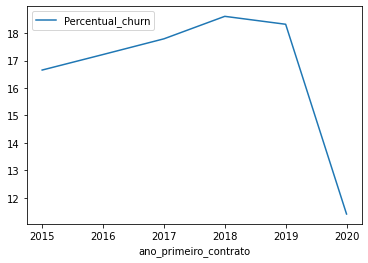

In [75]:
churn[['ano_primeiro_contrato','Percentual_churn']].plot(x='ano_primeiro_contrato', y='Percentual_churn');

### **Análise:**

Ja analisando o gráfico acima, é possível comprovar a Hipotes "H0", uma vez que percebemos a curva crescente entre os anos de 2015 a 2018, ou seja, o churn de novos clientes é maior do que o churn de clientes ativos.

OBS: Como não temos dados de 2021 e por termos utilizado dois anos para identificação do churn, os dados de 2019 e 2020 se tornam inviáveis nesta análise, mesmo que a quantidade de churn de 2019 seja tão relevante que demonstre uma tendencia de aumento quando incluirmos os dados de 2021.

### **Dando continuidade a análise dos dados de "Churn".**

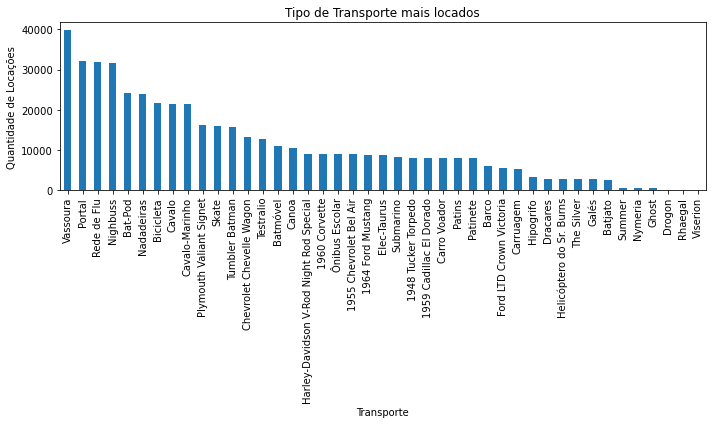

In [86]:
fig, ax = plt.subplots(figsize=(10,6))

df.transporte_locado.value_counts().plot(kind='bar', ax=ax)

ax.set_title("Tipo de Transporte mais locados")
ax.set_xlabel("Transporte")
ax.set_ylabel("Quantidade de Locações")

plt.tight_layout()

In [132]:
transporte_locado_df = df.pivot_table(index='transporte_locado', 
                                      columns='churn', 
                                      aggfunc='count', 
                                      values='cd_contrato', margins=True).reset_index()

transporte_locado_df.drop(transporte_locado_df[transporte_locado_df.transporte_locado=='All'].index, axis=0, inplace=True)

In [160]:
transporte_locado_df.head()

,transporte_locado,churn_false,churn_true,Total,Perc_churn
33,Rhaegal,43,3,46,6.521739
17,Drogon,53,3,56,5.357143
27,Nymeria,498,21,519,4.046243
23,Helicóptero do Sr. Burns,2578,108,2686,4.020849
36,Summer,507,21,528,3.977273


In [135]:
transporte_locado_df.columns = ['transporte_locado','churn_false','churn_true','Total']
transporte_locado_df.sort_values(by='Total', ascending=False, inplace=True)

In [149]:
transporte_locado_df['Perc_churn'] = transporte_locado_df.apply(lambda x: x.churn_true/x.Total*100, axis=1)

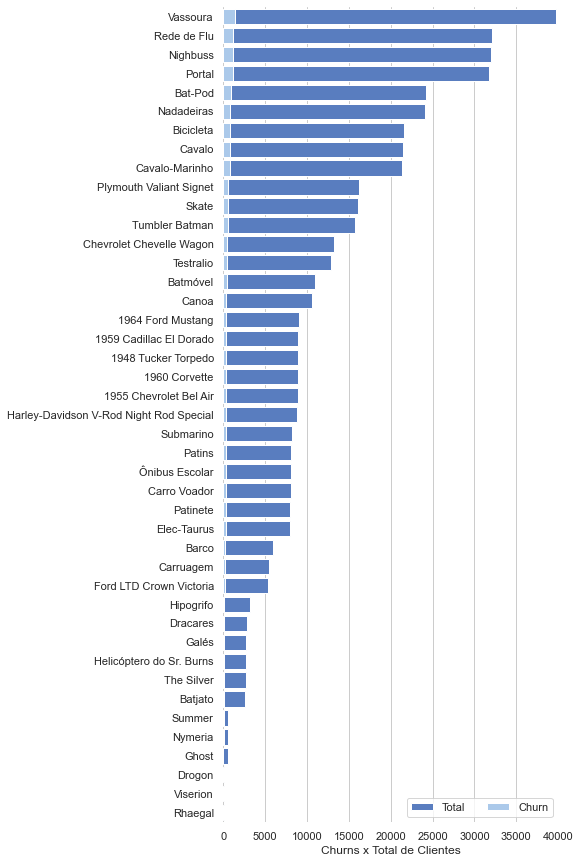

In [147]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(x="Total", y="transporte_locado", data=transporte_locado_df,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("pastel")
sns.barplot(x="churn_true", y="transporte_locado", data=transporte_locado_df,
            label="Churn", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 40000), ylabel="",
       xlabel="Churns x Tipos de Transportes locados")
sns.despine(left=True, bottom=True)

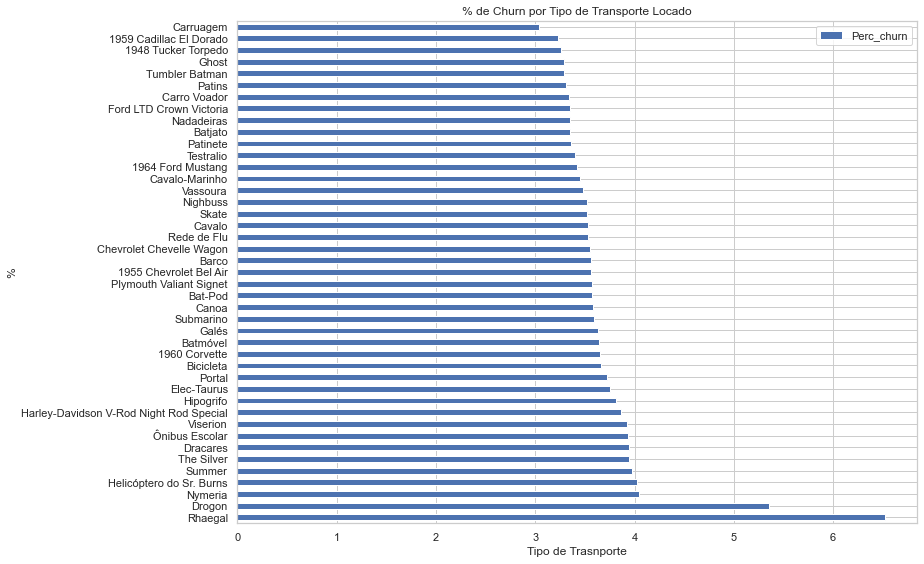

In [159]:
transporte_locado_df.sort_values(by='Perc_churn', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(13,8))

transporte_locado_df.plot(x="transporte_locado", y="Perc_churn", kind="barh", ax=ax)

ax.set_title("% de Churn por Tipo de Transporte Locado")
ax.set_xlabel("Tipo de Trasnporte")
ax.set_ylabel("%")

plt.tight_layout()

### **Análise:**

Analisando os dois gráficos acima não foi possível identificar uma relação clara entre a quantidade de churns e o tipo de transporte já que os que possuem um maior destaque(Rhaegal e Drogon), não podem ser considerados devido a quantidade de locações desses dois itens.



## Analisando os Churns por Cidade

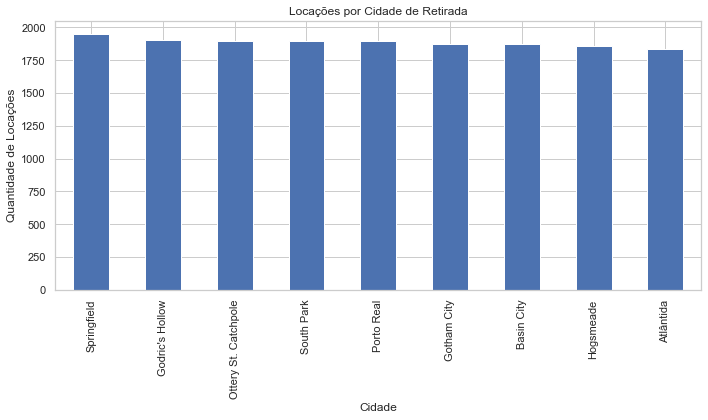

In [165]:
fig, ax = plt.subplots(figsize=(10,6))

where = df.churn==True
df[where].cidade_retirada.value_counts().plot(kind='bar', ax=ax)

ax.set_title("Locações por Cidade de Retirada")
ax.set_xlabel("Cidade")
ax.set_ylabel("Quantidade de Locações")

plt.tight_layout()

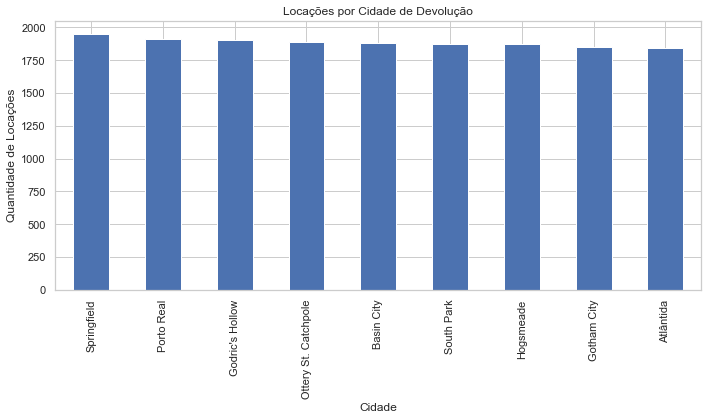

In [166]:
fig, ax = plt.subplots(figsize=(10,6))

where = df.churn==True
df[where].cidade_devolucao.value_counts().plot(kind='bar', ax=ax)

ax.set_title("Locações por Cidade de Devolução")
ax.set_xlabel("Cidade")
ax.set_ylabel("Quantidade de Locações")

plt.tight_layout()

In [168]:
df['dev_same_city'] = df.apply(lambda x: True if x.cidade_retirada==x.cidade_devolucao else False, axis=True)

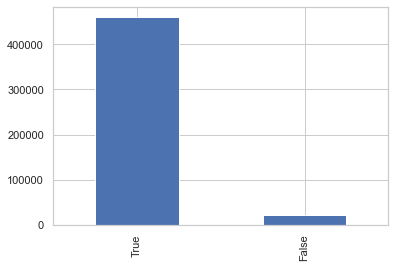

In [181]:
df['dev_same_city'].value_counts().plot(kind='bar');

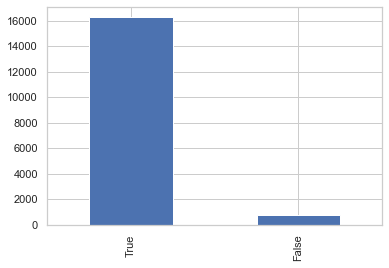

In [182]:
where = df.churn==True
df[where]['dev_same_city'].value_counts().plot(kind='bar');

In [193]:
df.qtd_diarias.describe()

count    480863.000000
mean          2.466301
std           1.892560
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          26.000000
Name: qtd_diarias, dtype: float64

In [194]:
where = df.churn==True
df[where].qtd_diarias.describe()

count    16970.000000
mean         2.515027
std          1.933521
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: qtd_diarias, dtype: float64

In [195]:
df.qtd_hora_extra.describe()

count    480863.000000
mean          0.110892
std           0.350490
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: qtd_hora_extra, dtype: float64

In [196]:
where = df.churn==True
df[where].qtd_hora_extra.describe()

count    16970.000000
mean         0.109075
std          0.342202
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: qtd_hora_extra, dtype: float64